# Import Libaries

In [69]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SubsetRandomSampler, random_split

from pinn_loss import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, rms_loss
from Input_vec_gen import input_gen, temp_data_gen, st_gen, meshgen, input_vgen
from Datagen import sim1d
from sampler import g_sampler, strat_sampler

# Generate Data

## Load Data 

In [70]:
L1 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=400670, temp_init=913.0, htc_l=10.0,htc_r= 12.0, length =15.0e-3)
                
L2 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=12.0,htc_r= 12.0, length =15.0e-3)
L3 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, 
               t_surr=298.0, L_fusion=377330, temp_init=913.0, htc_l=15.0,htc_r= 12.0, length =15.0e-3)          



Stable
Stable
Stable


## Extract the data

In [71]:
length = 15.0e-3 # length of the rod
time_end =40 # end time of the simulation
htc_l_1,htc_l_2,htc_l_3 = 10.0,12.0,15.0 # htc values for the 3 simulations
L_f1,L_f2,L_f3 = 400670.0,389000.0,377330.0 # Latent heat of fusion values for the 3 simulations

# Extract the temperature, space and time vectors from the simulation data
T1,space_1,time_1 = L1[0],L1[1],L1[2] # 1st element is the temperature matrix, 2nd is the space vector, 3rd is the time vector
T2,space_2,time_2 = L2[0],L2[1],L2[2]
T3,space_3,time_3 = L3[0],L3[1],L3[2]

# Convert the temperature, space and time vectors to numpy arrays
Temp_1,space_a1, time_a1 = np.array(T1),np.array(space_1),np.array(time_1)
Temp_2,space_a2, time_a2 = np.array(T2),np.array(space_2),np.array(time_2)
Temp_3,space_a3, time_a3 = np.array(T3),np.array(space_3),np.array(time_3)

dx = L1[3] # space step
dt = L1[4] # time step
length = L1[5] # length of the rod
time_end = L1[6] # end time of the simulation
num_steps = Temp_1.shape[0] # number of time steps
print(num_steps)
print(space_a1[0:10])

31470
[0.         0.00030612 0.00061224 0.00091837 0.00122449 0.00153061
 0.00183673 0.00214286 0.00244898 0.0027551 ]


In [72]:


# Normalize the data

# Temp_1n,Temp_2n, Temp_3n = scaler.fit_transform(Temp_1),scaler.fit_transform(Temp_2),scaler.fit_transform(Temp_3)
# Space_1n,Space_2n, Space_3n = scaler.fit_transform(space_a1.reshape(-1,1)),scaler.fit_transform(space_a2.reshape(-1,1)),scaler.fit_transform(space_a3.reshape(-1,1))
# Time_1n,Time_2n, Time_3n = scaler.fit_transform(time_a1.reshape(-1,1)),scaler.fit_transform(time_a2.reshape(-1,1)),scaler.fit_transform(time_a3.reshape(-1,1))

# print(Temp_1n.shape,Space_1n.shape,Time_1n.shape)


## Generate space and time input arrays

In [73]:
# a1 = input_gen(space_a1,time_a1,type='mgrid',scale=True)
# a2 = input_gen(space_a2,time_a2,type='mgrid',scale=True)
# a3 = input_gen(space_a3,time_a3,type='mgrid',scale=True)

# sp1,t_1 = a1[1],a1[2]
# sp2,t_2 = a2[1],a2[2]
# sp3,t_3 = a3[1],a3[2]

# print(sp1[:10])

space_a1, time_a1 = np.meshgrid(space_a1,time_a1)
space_a1 = space_a1.flatten()
time_a1 = time_a1.flatten()

scaler1 = StandardScaler()
sp1 = scaler1.fit_transform(space_a1.reshape(-1,1))
scaler2 = StandardScaler()
t_1 = scaler2.fit_transform(time_a1.reshape(-1,1))

sp2 = sp1
t_2 = t_1

sp3 = sp1
t_3 = t_1


print(sp1.shape,t_1.shape)



(1573500, 1) (1573500, 1)


## generate arrays for htc and Lf

In [74]:
def htc_gen(htc_l_1,space_a1):
    htc = np.ones_like(space_a1)*htc_l_1
    
    return htc

htcl_1 = htc_gen(htc_l_1,sp1)
htcl_2 = htc_gen(htc_l_2,sp2)
htcl_3 = htc_gen(htc_l_3,sp3)

htc_all = np.concatenate((htcl_1,htcl_2,htcl_3),axis=0)
scaler3 = StandardScaler()
htc_all = scaler3.fit_transform(htc_all.reshape(-1,1))
print(htc_all[0:10])

# print(htcl_1[0:10])

Lf_1 = htc_gen(L_f1,sp1)
Lf_2= htc_gen(L_f2,sp2)
Lf_3 = htc_gen(L_f3,sp3)
Lf_all = np.concatenate((Lf_1,Lf_2,Lf_3),axis=0)
scaler4 = StandardScaler()
Lf_all = scaler4.fit_transform(Lf_all.reshape(-1,1))
print(Lf_all.shape)

print(Lf_all[0:10]) 



[[-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]
 [-1.13554995]]
(4720500, 1)
[[1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]
 [1.22474487]]


## Combine all the input arrays into one set for each domain

In [75]:
# Generate the input vectors for the 3 simulations

spt_1 = input_vgen(sp1,t_1)

# input_1_pde = input_vgen(sp_pde_1,t_pde_1,htcl_pde_1,Lf_pde_1)
# input_1_ic = input_vgen(sp_ic_1,t_ic_1,htcl_ic_1,Lf_ic_1)
# input_1_bc_l = input_vgen(sp_bc_l_1,t_bc_l_1,htcl_bc_l_1,Lf_bc_l_1)
# input_1_bc_r = input_vgen(sp_bc_r_1,t_bc_r_1,htcl_bc_r_1,Lf_bc_r_1)


spt_2 = input_vgen(sp2,t_2)
# input_2_pde = input_vgen(sp_pde_2,t_pde_2,htcl_pde_2,Lf_pde_2)
# input_2_ic = input_vgen(sp_ic_2,t_ic_2,htcl_ic_2,Lf_ic_2)
# input_2_bc_l = input_vgen(sp_bc_l_2,t_bc_l_2,htcl_bc_l_2,Lf_bc_l_2)
# input_2_bc_r = input_vgen(sp_bc_r_2,t_bc_r_2,htcl_bc_r_2,Lf_bc_r_2)

spt_3 = input_vgen(sp3,t_3)
# input_3_pde = input_vgen(sp_pde_3,t_pde_3,htcl_pde_3,Lf_pde_3)
# input_3_ic = input_vgen(sp_ic_3,t_ic_3,htcl_ic_3,Lf_ic_3)
# input_3_bc_l = input_vgen(sp_bc_l_3,t_bc_l_3,htcl_bc_l_3,Lf_bc_l_3)
# input_3_bc_r = input_vgen(sp_bc_r_3,t_bc_r_3,htcl_bc_r_3,Lf_bc_r_3)
sp_all = np.concatenate((spt_1,spt_2,spt_3),axis=0)

inp_all = np.concatenate((sp_all,htc_all,Lf_all),axis=1)

print(inp_all.shape)

inp_1 = inp_all[0:sp1.shape[0],:]
inp_2 = inp_all[sp1.shape[0]:sp1.shape[0]+sp2.shape[0],:]
inp_3 = inp_all[sp1.shape[0]+sp2.shape[0]:,:]




(4720500, 4)


## Generate Output arrays for all,pde and bc/ic conditions

In [76]:
m1 = temp_data_gen(Temp_1) 
m2 = temp_data_gen(Temp_2)
m3 = temp_data_gen(Temp_3)

t1,t1_pde,t1_ic,t1_bc_l,t1_bc_r = m1[0],m1[1],m1[2],m1[3],m1[4]
t2,t2_pde,t2_ic,t2_bc_l,t2_bc_r = m2[0],m2[1],m2[2],m2[3],m2[4]
t3,t3_pde,t3_ic,t3_bc_l,t3_bc_r = m3[0],m3[1],m3[2],m3[3],m3[4]



## Combining all inputs of three simulations and scale it

In [77]:

scaler5 = StandardScaler()
# inp_all = np.concatenate((input_1,input_2,input_3),axis=0)
# print(inp_all.shape)
# inp_all = scaler.fit_transform(inp_all)
# print(inp_all.shape)
# inp_pde_all = np.concatenate((input_1_pde,input_2_pde,input_3_pde),axis=0)
# inp_ic_all = np.concatenate((input_1_ic,input_2_ic,input_3_ic),axis=0)
# inp_bc_l_all = np.concatenate((input_1_bc_l,input_2_bc_l,input_3_bc_l),axis=0)
# inp_bc_r_all = np.concatenate((input_1_bc_r,input_2_bc_r,input_3_bc_r),axis=0)

temp_all = np.concatenate((t1,t2,t3),axis=0)
temp_all = scaler5.fit_transform(temp_all)
print(temp_all.shape)
# temp_pde_all = np.concatenate((t1_pde,t2_pde,t3_pde),axis=0)
# temp_ic_all = np.concatenate((t1_ic,t2_ic,t3_ic),axis=0)
# temp_bc_l_all = np.concatenate((t1_bc_l,t2_bc_l,t3_bc_l),axis=0)
# temp_bc_r_all = np.concatenate((t1_bc_r,t2_bc_r,t3_bc_r),axis=0)

print(inp_all[:5,:])
print(temp_all[:5,:])

(4720500, 1)
[[-1.69774938 -1.73199577 -1.13554995  1.22474487]
 [-1.62845348 -1.73199577 -1.13554995  1.22474487]
 [-1.55915759 -1.73199577 -1.13554995  1.22474487]
 [-1.4898617  -1.73199577 -1.13554995  1.22474487]
 [-1.4205658  -1.73199577 -1.13554995  1.22474487]]
[[1.62694661]
 [1.62694661]
 [1.62694661]
 [1.62694661]
 [1.62694661]]


# Plot the three simulations

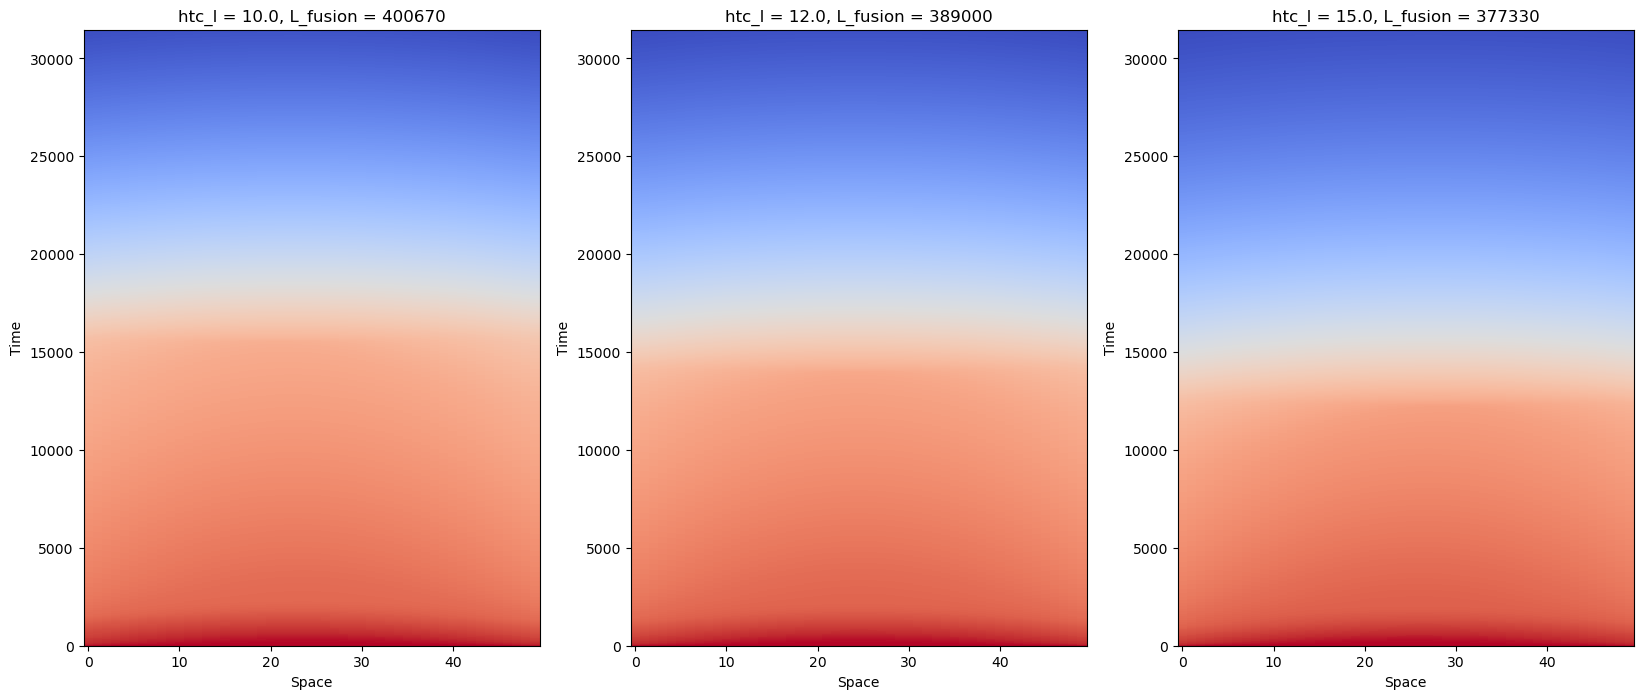

In [78]:
# plt a subplot of the three plots
space_cord, time_cord = np.meshgrid(np.arange(T1.shape[1]), np.arange(T1.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].pcolormesh(space_cord, time_cord, T1, cmap='coolwarm', shading='auto')
axs[0].set_title('htc_l = 10.0, L_fusion = 400670')
axs[0].set_xlabel('Space')
axs[0].set_ylabel('Time')
axs[1].pcolormesh(space_cord, time_cord, T2, cmap='coolwarm', shading='auto')
axs[1].set_title('htc_l = 12.0, L_fusion = 389000')
axs[1].set_xlabel('Space')
axs[1].set_ylabel('Time')
axs[2].pcolormesh(space_cord, time_cord, T3, cmap='coolwarm', shading='auto')
axs[2].set_title('htc_l = 15.0, L_fusion = 377330')
axs[2].set_xlabel('Space')
axs[2].set_ylabel('Time')
plt.show()


# Check for GPU

In [79]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device2 = torch.device('cpu')
print('Using device:', device)

Using device: cuda


# Data Preparation

## Sampler Preparation



In [80]:
# Stratified sampler is used to sample the input and output from the 3 simulations

t_surr = 298.0 # Surrounding temperature
t_init = 913.0 # Initial temperature

inputs_sam, T_sam = strat_sampler(inp_all,temp_all,0.10) # Sample the input and output data
# inputs_pde_sam, T_pde_sam = strat_sampler(inp_pde_all,temp_pde_all,0.1) # Sample the input and output data for pde 
# inputs_i_sam,T_ic_sam = strat_sampler(inp_ic_all,temp_ic_all,1) # Sample the input and output data for initial condition
# inputs_b_l_sam,T_bcl_sam = strat_sampler(inp_bc_l_all,temp_bc_l_all,0.2) # Sample the input and output data for boundary condition left
# inputs_b_r_sam, T_bcr_sam = strat_sampler(inp_bc_r_all, temp_bc_r_all, 0.2) # Sample the input and output data for boundary condition right

print(inputs_sam.shape,T_sam.shape)
# print(inputs_pde_sam.shape,T_pde_sam.shape)
# print(inputs_i_sam.shape,T_ic_sam.shape)
# print(inputs_b_l_sam.shape,T_bcl_sam.shape)
# print(inputs_b_r_sam.shape,T_bcr_sam.shape)


(472050, 4) (472050, 1)


## Tensor the Sample Dataset

In [81]:
inp_all, temp_all = torch.tensor(inp_all).float(), torch.tensor(temp_all).float()
# inp_pde_sam, T_pde_sam = torch.tensor(inputs_pde_sam).float(), torch.tensor(T_pde_sam).float()
# inp_i_sam, T_ic_sam = torch.tensor(inputs_i_sam).float(), torch.tensor(T_ic_sam).float()
# inp_b_l_sam, T_bcl_sam = torch.tensor(inputs_b_l_sam).float(), torch.tensor(T_bcl_sam).float()
# inp_b_r_sam, T_bcr_sam = torch.tensor(inputs_b_r_sam).float(), torch.tensor(T_bcr_sam).float()


## Data splitting

In [82]:
train_inp_sam,test_inp_sam,train_T_sam,test_T_sam = train_test_split(inp_all,temp_all,\
                                                                     test_size=0.2,random_state=42)
# train_inp_pde_sam,test_inp_pde_sam,train_T_pde_sam,test_T_pde_sam = train_test_split(inp_pde_sam,T_pde_sam,\
#                                                                                      test_size=0.2,random_state=42)
# train_inp_i_sam,test_inp_i_sam,train_T_i_sam,test_T_i_sam = train_test_split(inp_i_sam,T_ic_sam,\
#                                                                              test_size=0.2,random_state=42)
# train_inp_b_l_sam,test_inp_b_l_sam,train_T_b_l_sam,test_T_b_l_sam = train_test_split(inp_b_l_sam,T_bcl_sam, \
#                                                                                      test_size=0.2,random_state=42)
# train_inp_b_r_sam,test_inp_b_r_sam,train_T_b_r_sam,test_T_b_r_sam = train_test_split(inp_b_r_sam,T_bcr_sam,\
#                                                                                      test_size=0.2,random_state=42)
print(train_inp_sam.shape,train_T_sam.shape)
print(test_inp_sam.shape,test_T_sam.shape)

torch.Size([3776400, 4]) torch.Size([3776400, 1])
torch.Size([944100, 4]) torch.Size([944100, 1])


## Dataloader

In [83]:
class PinnDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        X = self.inputs[idx]
        y = self.targets[idx]
        return X, y

## Dataset Prep

In [84]:
train_dataset = PinnDataset(train_inp_sam, train_T_sam)
test_dataset = PinnDataset(test_inp_sam, test_T_sam)

# train_pde_dataset = PinnDataset(train_inp_pde_sam, train_T_pde_sam)
# test_pde_dataset = PinnDataset(test_inp_pde_sam, test_T_pde_sam)

# train_ic_dataset = PinnDataset(train_inp_i_sam, train_T_i_sam)
# test_ic_dataset = PinnDataset(test_inp_i_sam, test_T_i_sam)

# train_b_l_dataset = PinnDataset(train_inp_b_l_sam, train_T_b_l_sam)
# test_b_l_dataset = PinnDataset(test_inp_b_l_sam, test_T_b_l_sam)

# train_b_r_dataset = PinnDataset(train_inp_b_r_sam, train_T_b_r_sam)
# test_b_r_dataset = PinnDataset(test_inp_b_r_sam, test_T_b_r_sam)


In [85]:
#try random sampler if it doesnt work

In [86]:
batch_size = 256
sample_size = 1000
random_sampler_train = RandomSampler(train_dataset, replacement=True, num_samples=sample_size) # Create a random sampler for the test dataset
random_sampler_test = RandomSampler(test_dataset, replacement=True, num_samples=sample_size) # Create a random sampler for the test dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=random_sampler_train) # Create a dataloader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=random_sampler_test) # Create a dataloader for the test dataset

# train_pde_loader = DataLoader(train_pde_dataset, batch_size=64, shuffle=True)
# test_pde_loader = DataLoader(test_pde_dataset, batch_size=64, shuffle=True)

# train_ic_loader = DataLoader(train_ic_dataset, batch_size=64, shuffle=True)
# test_ic_loader = DataLoader(test_ic_dataset, batch_size=64, shuffle=True)

# train_b_l_loader = DataLoader(train_b_l_dataset, batch_size=64, shuffle=True)
# test_b_l_loader = DataLoader(test_b_l_dataset, batch_size=64, shuffle=True)

# train_b_r_loader = DataLoader(train_b_r_dataset, batch_size=64, shuffle=True)
# test_b_r_loader = DataLoader(test_b_r_dataset, batch_size=64, shuffle=True)


# Model Development

In [87]:
# prepare data into interior , boundary and initial condition
class Pinn_Var(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(Pinn_Var, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(), 
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Tanh(),           
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x, t, h,Lf):                               # This is the forward pass
        input_features = torch.cat([x, t, h,Lf], dim=1)          # Concatenate the input features
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network



In [88]:
# Hyperparameters
hidden_size = 20
learning_rate = 0.009
epochs = 10001
# alpha = 0.01  # Adjust this value based on your problem
# boundary_value = 313.0
# initial_value = init_temp
# Initialize the model
model = Pinn_Var(input_size=4, hidden_size=hidden_size,output_size=1).to(device)
lambd = 0.1

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Training & Testing Loop 

In [89]:
train_losses = []
val_losses = []
test_losses = []

In [90]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_loader,test_dataloader):
    train_losses = []  # Initialize the list to store the training losses
    # val_losses = []    # Initialize the list to store the validation losses
    test_losses = []   # Initialize the list to store the test losses
    data_losses = []   # Initialize the list to store the data losses
   
    #Initialize the list to store the boundary condition losses

    for epoch in range(epochs):
        model.train()                                                                           # Set the model to training mode
        train_loss = 0                                                                              # Initialize the training loss
        
        
        for batch in train_loader:                                                          # Loop through the training dataloader
            
            train_inputs_sample, train_T_sam= batch                                                             # Get the inputs and the true values
            
                                                                         # Get the inputs and the true values

            train_inputs_sample, train_T_sam = train_inputs_sample.to(device), train_T_sam.to(device)                                                             # Get the inputs and the true values
            optimizer.zero_grad()                                                                    # Zero the gradients
            
            sp = train_inputs_sample[:,0].unsqueeze(1)
            t = train_inputs_sample[:,1].unsqueeze(1)
            h = train_inputs_sample[:,2].unsqueeze(1)
            Lf = train_inputs_sample[:,3].unsqueeze(1)
                       
            # Forward pass
            u_pred = model(sp,t,h,Lf)                       # Get the predictions
                         
            # Loss calculation
            data_loss = loss_fn_data(u_pred, train_T_sam)                                              # Calculate the data loss
            loss = data_loss 
                                                                 
            
            # Backpropagation
            loss.backward(retain_graph=True)                                                        # Backpropagate the gradients
            optimizer.step()                                                                           # Update the weights
            
            train_loss += loss.item()                                                           # Add the loss to the training set loss  
            
        
        train_losses.append(train_loss)
        

        # torch.cuda.empty_cache()
        model.eval()
        test_loss = 0
        test_accuracy = 0
        with torch.no_grad(): 
            for batch in test_dataloader:
                test_inputs_sample, test_temp_inp_sample= batch
                test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
                
                sp = test_inputs_sample[:,0].unsqueeze(1)
                t = test_inputs_sample[:,1].unsqueeze(1)
                h = test_inputs_sample[:,2].unsqueeze(1)
                Lf = test_inputs_sample[:,3].unsqueeze(1)
                       
            # Forward pass
                u_pred = model(sp,t,h,Lf)                       
                data_loss_t = loss_fn_data(u_pred, test_temp_inp_sample)              
                
                loss = data_loss_t
               
                test_loss += loss.item()
        test_losses.append(test_loss)

                                                           # Append the training loss to the list of training losses
        
        torch.cuda.empty_cache()


        if epoch % 10 == 0:
            print(f"|Epoch {epoch}| Training-Loss {train_loss:.4e}| test-loss {test_loss:.4e} | ")
            print('--'*20)
           

    return train_losses, test_losses,data_losses                                                     # Return the training and validation losses


In [91]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
    for epoch in range(epochs):
        model.eval()
        test_loss = 0
        test_accuracy = 0
        with torch.no_grad():   
            for batch in test_dataloader:
                test_inputs_sample, test_temp_inp_sample= batch
                test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
                u_pred = model(test_inputs_sample[:,0].unsqueeze(1), test_inputs_sample[:,1].unsqueeze(1))
                data_loss = loss_fn_data(u_pred, test_temp_inp_sample)
               
                
                loss = data_loss
                test_accuracy = accuracy(u_pred, test_temp_inp_sample)
                test_loss += loss.item()
        test_losses.append(test_loss)
        if epochs % 10 == 0:
            print(f"Epoch {epoch}, Test-Loss {test_loss:.4e}, Test-Accuracy {test_accuracy:.4e}")      
    return test_losses

# Model Run

In [92]:

train_losses, test_losses, data_losses= training_loop(epochs, model, \
                                       loss_fn_data, optimizer,train_loader,test_loader,\
                                            )  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model


   


    
    

|Epoch 0| Training-Loss 2.9975e+00| test-loss 1.2061e+00 | 
----------------------------------------
|Epoch 10| Training-Loss 4.7053e-02| test-loss 2.7170e-02 | 
----------------------------------------
|Epoch 20| Training-Loss 2.5132e-02| test-loss 2.5584e-02 | 
----------------------------------------
|Epoch 30| Training-Loss 2.4991e-02| test-loss 2.2462e-02 | 
----------------------------------------
|Epoch 40| Training-Loss 2.4770e-02| test-loss 2.7364e-02 | 
----------------------------------------
|Epoch 50| Training-Loss 2.4078e-02| test-loss 2.1429e-02 | 
----------------------------------------
|Epoch 60| Training-Loss 2.1748e-02| test-loss 1.7816e-02 | 
----------------------------------------
|Epoch 70| Training-Loss 2.2094e-02| test-loss 2.2964e-02 | 
----------------------------------------
|Epoch 80| Training-Loss 2.2172e-02| test-loss 2.0602e-02 | 
----------------------------------------
|Epoch 90| Training-Loss 2.1293e-02| test-loss 2.0837e-02 | 
----------------------

# Plots

(1573500, 4)
(1573500, 4)
1573500
(1573500, 1)
(31470,)
(1573500, 1)
(31470, 50)


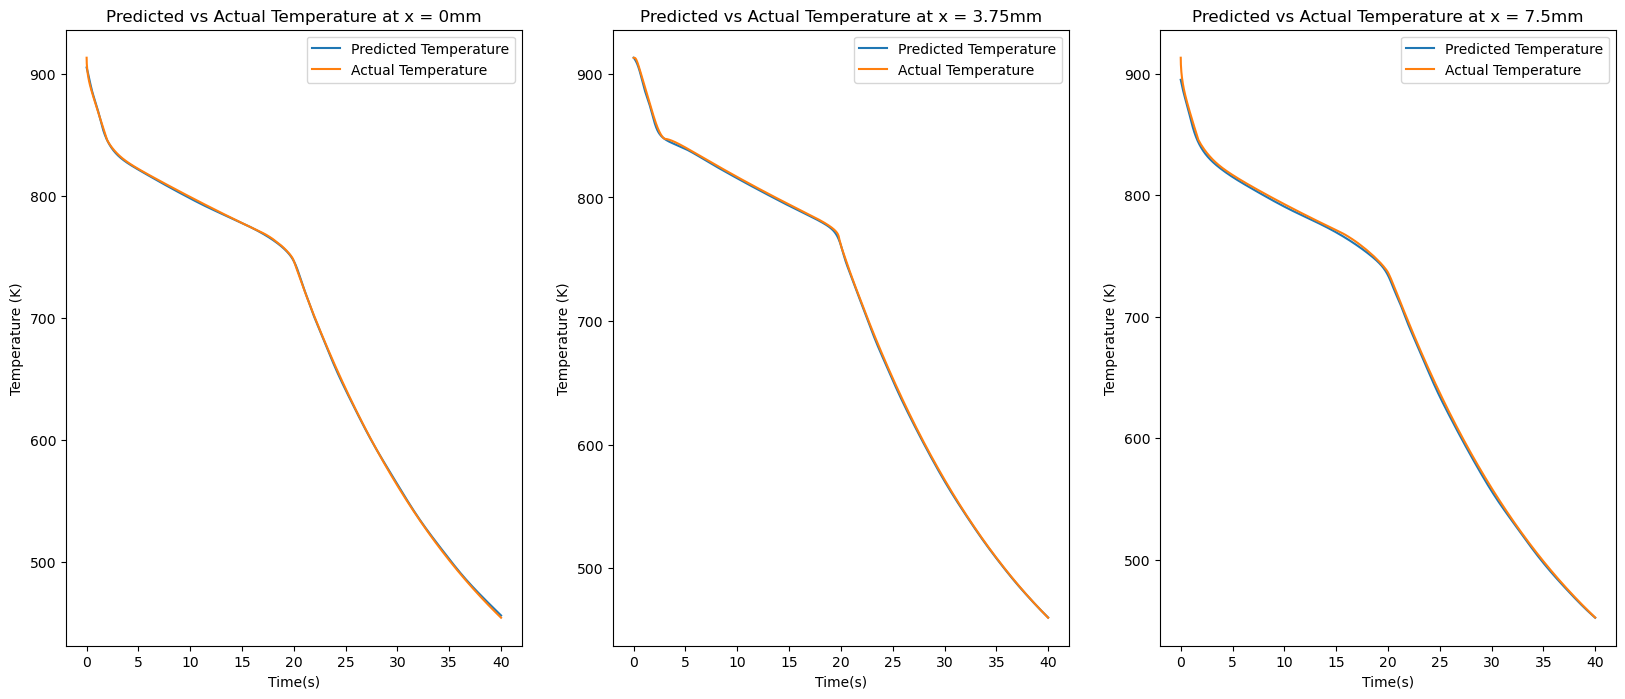

In [93]:
torch.cuda.empty_cache()


print(inp_1.shape)
input_1 = inp_1
print(input_1.shape)
inputs = torch.tensor(input_1).float().to(device) # Convert the inputs to a tensor
temp_nn = model(inputs[:,0].unsqueeze(1), \
            inputs[:,1].unsqueeze(1),\
                inputs[:,2].unsqueeze(1), inputs[:,3].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
num_points = space_a1.shape[0] # Number of points in the space vector
print(num_points)
print(temp_nn.shape)

temp_nn = scaler5.inverse_transform(temp_nn) # Inverse transform the predictions

time_ss = np.linspace(0, time_end, num_steps) # Generate the time vector

print(time_ss.shape)
print(temp_nn.shape)
temp_nn = temp_nn.reshape((temp_nn.shape[0]//50),50) # Reshape the predictions to a 2D array
print(temp_nn.shape)

# print(temp_nn[0,:])
# time_ss= np.linspace(0, time_end, dt)fig
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.plot(time_ss, temp_nn[:, 0], label='Predicted Temperature')
ax1.plot(time_ss, T1[:,0], label='Actual Temperature')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Predicted vs Actual Temperature at x = 0mm')
ax1.legend()

ax2.plot(time_ss, temp_nn[:, 25], label='Predicted Temperature')
ax2.plot(time_ss, T1[:,25], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Predicted vs Actual Temperature at x = 3.75mm')
ax2.legend()

ax3.plot(time_ss, temp_nn[:, 50-1], label='Predicted Temperature')
ax3.plot(time_ss, T1[:,50-1], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title('Predicted vs Actual Temperature at x = 7.5mm')
ax3.legend()
plt.show()




(1573500, 4)
(1573500, 1)
(31470,)


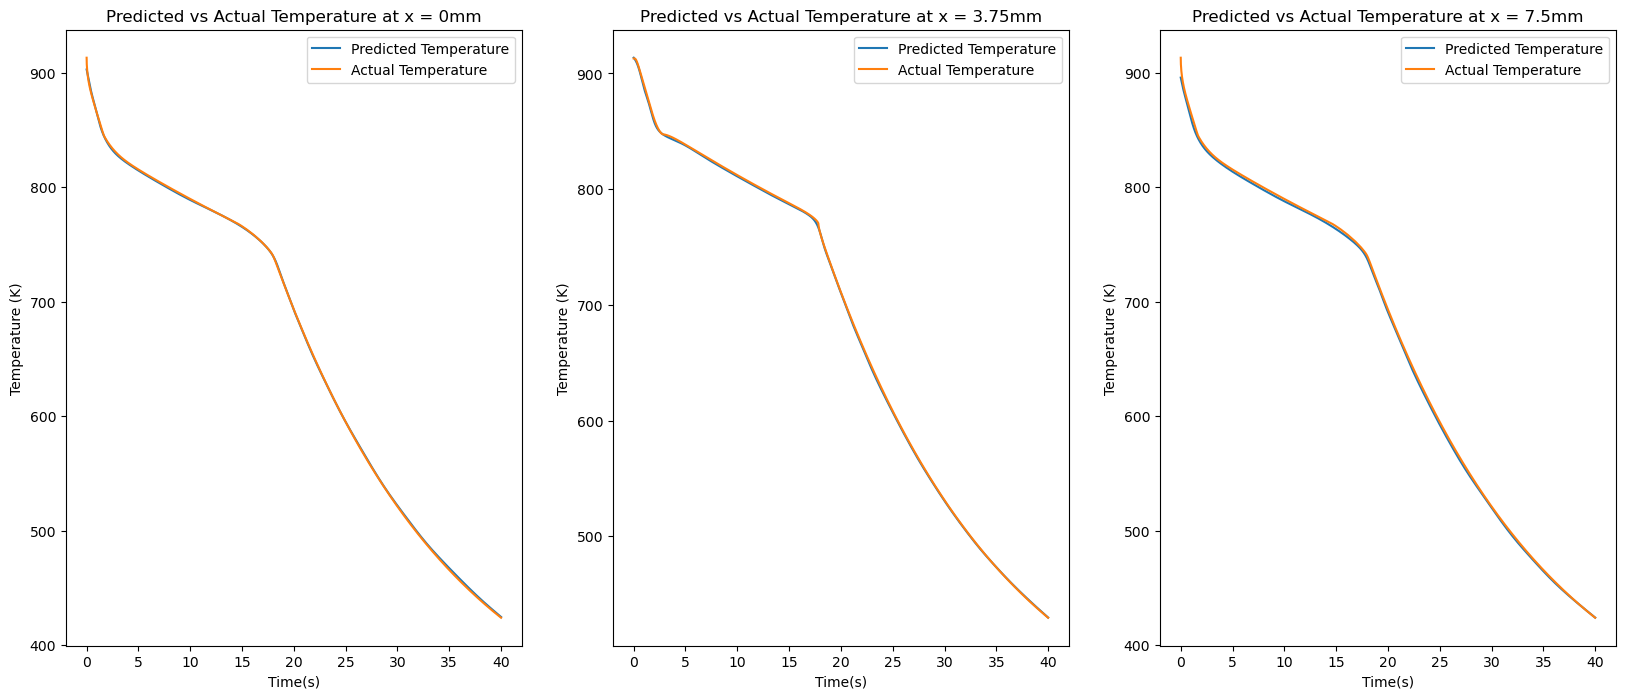

In [94]:
torch.cuda.empty_cache()
input_2 = inp_2
print(input_2.shape)
inputs = torch.tensor(input_2).float().to(device) # Convert the inputs to a tensor
temp_nn_2 = model(inputs[:,0].unsqueeze(1), \
            inputs[:,1].unsqueeze(1),\
                inputs[:,2].unsqueeze(1), inputs[:,3].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
num_points = space_a1.shape[0] # Number of points in the space vector
print(temp_nn_2.shape)

temp_nn_2 = scaler5.inverse_transform(temp_nn_2) # Inverse transform the predictions

time_ss = np.linspace(0, time_end, num_steps) # Generate the time vector

print(time_ss.shape)
# print(temp_nn.shape[0])
temp_nn_2 = temp_nn_2.reshape((temp_nn_2.shape[0]//50),50) # Reshape the predictions to a 2D array
# print(temp_nn.shape)

# print(temp_nn[0,:])
# time_ss= np.linspace(0, time_end, dt)fig
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.plot(time_ss, temp_nn_2[:, 0], label='Predicted Temperature')
ax1.plot(time_ss, T2[:,0], label='Actual Temperature')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Predicted vs Actual Temperature at x = 0mm')
ax1.legend()

ax2.plot(time_ss, temp_nn_2[:, 25], label='Predicted Temperature')
ax2.plot(time_ss, T2[:,25], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Predicted vs Actual Temperature at x = 3.75mm')
ax2.legend()

ax3.plot(time_ss, temp_nn_2[:, 49], label='Predicted Temperature')
ax3.plot(time_ss, T2[:,49], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title('Predicted vs Actual Temperature at x = 7.5mm')
ax3.legend()
plt.show()




(1573500, 4)
(31470, 50)
(31470,)


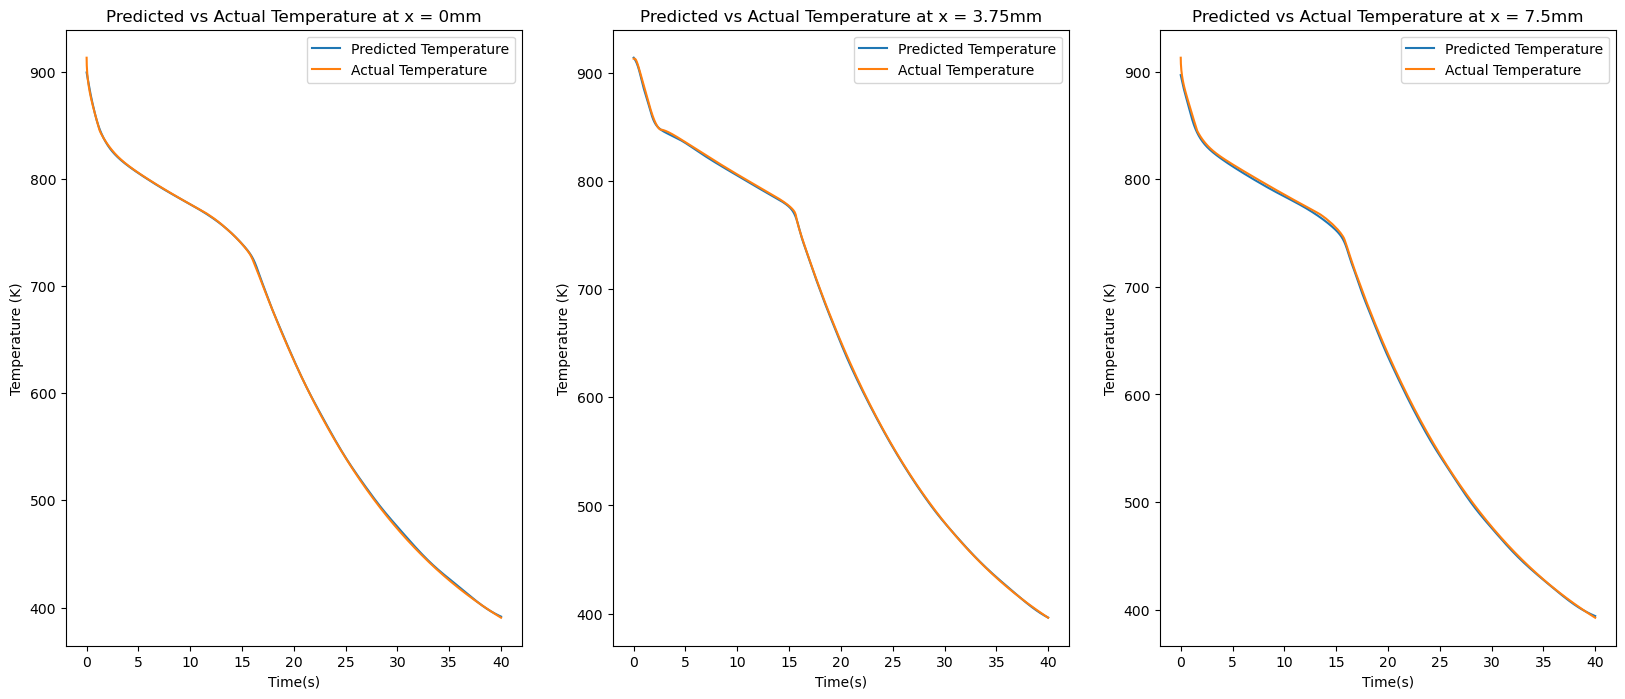

In [95]:
torch.cuda.empty_cache()
input_3 = inp_3
print(input_3.shape)
inputs = torch.tensor(input_3).float().to(device) # Convert the inputs to a tensor
temp_nn_3 = model(inputs[:,0].unsqueeze(1), \
            inputs[:,1].unsqueeze(1),\
                inputs[:,2].unsqueeze(1), inputs[:,3].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
num_points = space_a1.shape[0] # Number of points in the space vector
print(temp_nn.shape)

temp_nn_3 = scaler5.inverse_transform(temp_nn_3) # Inverse transform the predictions

time_ss = np.linspace(0, time_end, num_steps) # Generate the time vector

print(time_ss.shape)
# print(temp_nn.shape[0])
temp_nn_3 = temp_nn_3.reshape((temp_nn_3.shape[0]//50),50) # Reshape the predictions to a 2D array
# print(temp_nn.shape)

# print(temp_nn[0,:])
# time_ss= np.linspace(0, time_end, dt)fig
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.plot(time_ss, temp_nn_3[:, 0], label='Predicted Temperature')
ax1.plot(time_ss, T3[:,0], label='Actual Temperature')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Predicted vs Actual Temperature at x = 0mm')
ax1.legend()

ax2.plot(time_ss, temp_nn_3[:, 25], label='Predicted Temperature')
ax2.plot(time_ss, T3[:,25], label='Actual Temperature')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Predicted vs Actual Temperature at x = 3.75mm')
ax2.legend()

ax3.plot(time_ss, temp_nn_3[:, 49], label='Predicted Temperature')
ax3.plot(time_ss, T3[:,49], label='Actual Temperature')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Temperature (K)')
ax3.set_title('Predicted vs Actual Temperature at x = 7.5mm')
ax3.legend()
plt.show()




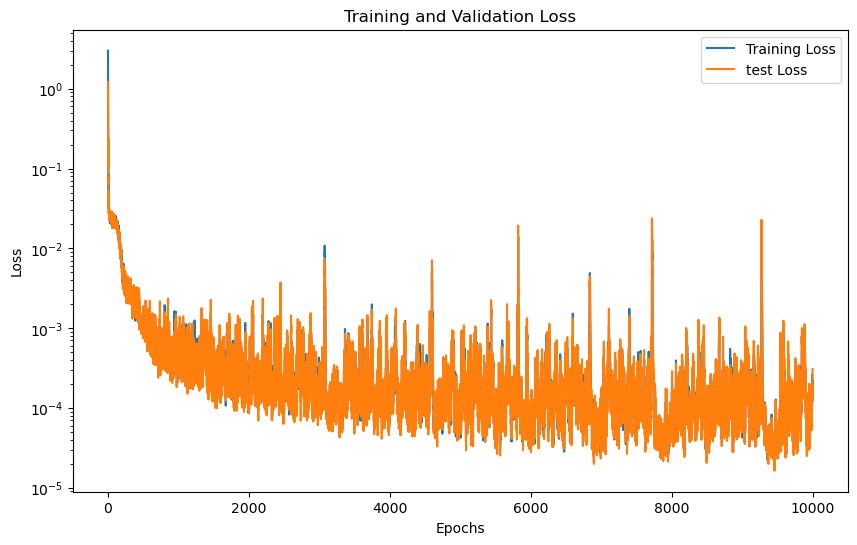

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='test Loss')
# plt.xticks(np.arange(0, epochs, 10000))
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [97]:
# pde_losses_n = [tensor.cpu().detach().numpy() for tensor in pde_losses]
# data_losses_n = [tensor.cpu().detach().numpy() for tensor in data_losses]
# ic_losses_n = [tensor.cpu().detach().numpy() for tensor in ic_losses]
# bc_losses_n = [tensor.cpu().detach().numpy() for tensor in bc_losses]

# plt.figure(figsize=(10, 6))
# plt.plot(data_losses_n, label='Data Loss')
# plt.plot(pde_losses_n, label='Pde Loss')
# plt.plot(ic_losses_n, label='IC Loss')
# plt.plot(bc_losses_n, label='BC Loss')
# plt.yscale('log')
# # plt.axhline(y=1e-6, color='red', linestyle='--', label='Near-Zero Line')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

(31470, 50) (31470, 50) (31470, 50) (31470, 50)


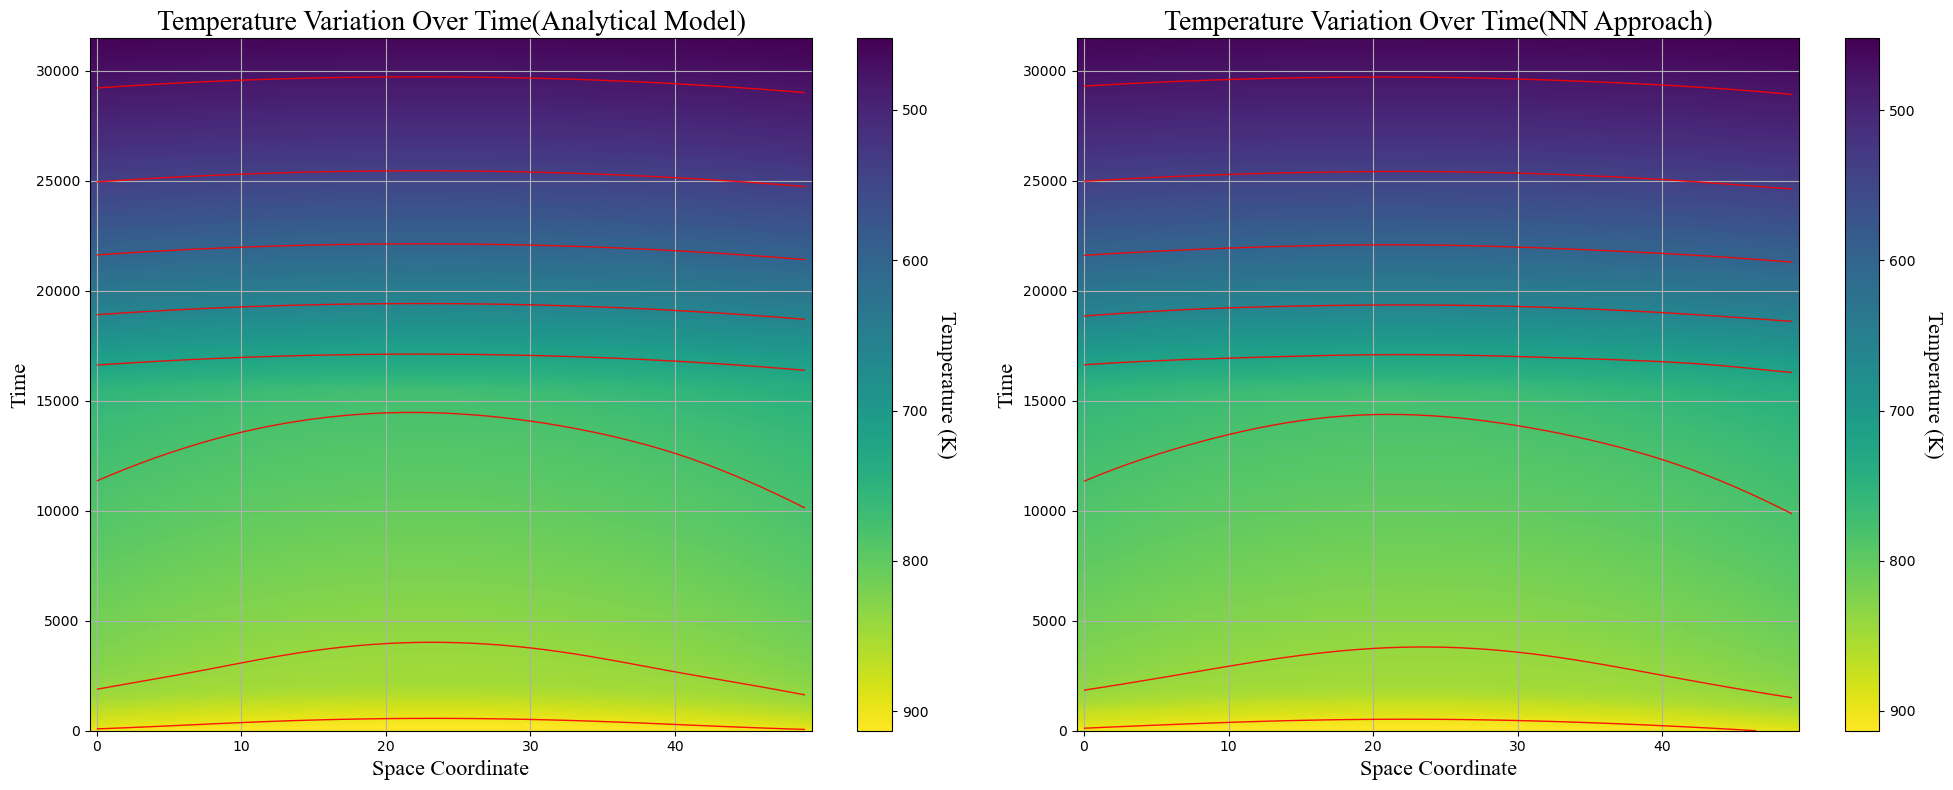

In [98]:
space_coord, time_coord = np.meshgrid(np.arange(T1.shape[1]), np.arange(T1.shape[0]))

# time_coord = time_coord * dt 
# Create a figure with two subplots
print(space_coord.shape,time_coord.shape,T1.shape,temp_nn.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, T1, cmap='viridis', shading='auto')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time(Analytical Model)',fontname='Times New Roman', fontsize=20)
ax1.contour(space_coord, time_coord, T1, colors='red', linewidths=1.0, alpha=0.9)

ax1.grid(True)
cbar = fig.colorbar(im1, ax=ax1)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='viridis', shading='auto')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(NN Approach)',fontname='Times New Roman', fontsize=20)
ax2.contour(space_coord, time_coord, temp_nn, colors='red', linewidths=1.0, alpha=0.9)

ax2.grid(True)
cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)


plt.tight_layout()
plt.show()
